# 1D nonlinear stationary Schrodinger solitons

This is probably the simplest soliton you can possibly have.
Consider a Hamiltonian of the form
$$
\hat{H} = -\frac{1}{2} \frac{d^2}{dx^2} + V.
$$
The potential $V$ is a combination of a low-density attractive term, and a high-density repulsive term
$$ V(\psi) = \alpha (|\psi|^2 - \bar{\psi}^2)^2 = -\alpha \bar{\psi}^2 |\psi|^2 + \alpha |\psi|^4 $$ 
Naively, this should result in a vacuum expectation value of $\langle \psi \rangle = \bar{\psi}$. However, if the Hamiltonian is invariant under global phase rotations $\psi \rightarrow e^{i\theta} \psi$ (as this one is), then particle number is conserved, and the vacuum cannot reach the minimum of the potential except in localized areas (aka solitons).
The time-independent equation of motion is
$$
-\frac{1}{2m} \frac{d^2\psi}{dx^2} + \alpha(|\psi|^2 - \bar{\psi}^2)^2\psi = E \psi
$$
which we can solve in order to find the form of these solitons.
Unfortunately this equation is too complicated to solve for analytically, so we will have to resort to approximate solutions.
I will show an approximate analytical solution using the "variational method", and also a numerical algorithm that falls into a class of "relaxation methods".

## Approximate variational solution

Before jumping straight to a numerical solution, I will introduce the variational method, a simple way to get approximate analytic solutions for a wide array of complex solitonic configurations. The basic recipe is:
* pick a simple "trial" wave function $\psi$, parametrized by some variables $\theta_i$
* compute the expectation value of the energy due to this trial wave function via $E = \langle \psi | \hat{H} | \psi \rangle / \langle \psi | \psi \rangle$
* minimize the energy by solving $\partial E/\partial \theta_i = 0$

Because the energy spectrum is typically bounded from below (unless you choose a non-physical potential), the minimization will typically give you a trial wave function that approximates the ground state.
You can also derive excited states by chosing a trial wavefunction that matches the symmetry or number of nodes of the excited states
* e.g. a typical trial wave function for the ground state is a simple Gaussian $\psi(x) \sim \exp(-(x/R)^2)$
* an excited state might have an antisymmetric wave function like $\psi(x) \sim x\exp(-(x/R)^2)$

To get an approximate ground state for our soliton, we will also assume a Gaussian ansatz.

In [3]:
import sympy as sp
x = sp.symbols("x", real=True)
R, ps0 = sp.symbols(r"R \psi_0", positive=True)
psi = sp.Function(r"\psi", real=True)

# this is the gaussian wave function profile
def psi_ansatz(x):
    return ps0 * sp.exp(-(x/R)**2)
sp.Eq(psi(x), psi_ansatz(x))

Eq(\psi(x), \psi_0*exp(-x**2/R**2))

However, because of the nonlinearities in the potential, the normalization of our wave function actually matters since the self-interaction depends on it.
We will normalize the wave function so that it represents a condensate of $N$ particles, rather than just a single particle, which means $\langle \psi | \psi \rangle = N$

In [4]:
N = sp.symbols("N", positive=True)
# we normalize the wave function to <psi|psi> = N
eq = sp.Equality(
    N, sp.integrate(abs(psi_ansatz(x))**2, (x, -sp.oo, sp.oo))
)
eq

Eq(N, sqrt(2)*sqrt(pi)*R*\psi_0**2/2)

We can now solve for the normalization factor $\psi_0$ in terms of the parameters $N$ and $R$.

In [5]:
# solve for \psi_0 in terms of N, R
ps0_sol = sp.solve(eq, ps0)[0]
sp.Eq(ps0, ps0_sol)

Eq(\psi_0, 2**(1/4)*sqrt(N)/(pi**(1/4)*sqrt(R)))

The variational energy is simply the normalized expectation value as explained above. I will do a little trick and subtract off the vacuum energy $\alpha \bar{\psi}^4$ so that $V(0) = 0$ (this doesn't affect the physics at all since only differences in energy are physical, not absolute values).

In [12]:
m, psb, a = sp.symbols(r"m \bar{\psi} \alpha", positive=True)
# calculate (one-dimensional) the energy density
f = psi_ansatz
energy_density = (
    -(1/(2*m))*sp.diff(f(x), x, x)*f(x) # kinetic term
    + a*((f(x)**2 - psb**2)**2 - psb**4)*(f(x)**2) # potential term
).subs(ps0, ps0_sol)/N
# variational energy
E_var = sp.integrate(energy_density, (x, -sp.oo, sp.oo))
sp.Eq(sp.symbols(r"\widetilde{E}"), E_var)

Eq(\widetilde{E}, 2*sqrt(3)*N**2*\alpha/(3*pi*R**2) - 2*N*\alpha*\bar{\psi}**2/(sqrt(pi)*R) + 1/(2*R**2*m))

Now we minimize $\widetilde{E}$ with respect to $R$, holding $N$ constant, by solving $\partial \widetilde{E}/\partial R = 0$

In [13]:
# minimize with respect to R
sol = sp.solveset(sp.Eq(sp.diff(E_var, R), 0), R)
sp.Eq(R, sol.args[0].simplify())

Eq(R, (4*sqrt(3)*N**2*\alpha*m + 3*pi)/(6*sqrt(pi)*N*\alpha*\bar{\psi}**2*m))

This looks a little messy, so I will rewrite it in a little neater form:
$$
R = R_0 \frac{\widetilde{N}^2 + 1}{3^{1/4} \widetilde{N}}, \\ \text{where} \quad
R_0 = (\sqrt{\alpha m} \bar{\psi}^2)^{-1}, \quad
\widetilde{N} = \frac{2\sqrt{\alpha m}}{3^{1/4} \sqrt{\pi}} N
$$


In [17]:
# confirm rewritten stuff is equivalent
R0 = 1/(sp.sqrt(a*m)*(psb**2))
Nt = (2*sp.sqrt(a*m))/(sp.Pow(3,sp.Rational(1,4))*sp.sqrt(sp.pi))*N
(R0*(Nt**2 + 1)/(sp.Pow(3, sp.Rational(1, 4))*Nt) - sol.args[0]).simplify() == 0

True

We can see that for $\widetilde{N} \ll 1$ the radius actually decreases with increasing quanta like $O(1/N)$, but for $\widetilde{N} \gg 1$ the radius increses linearly.
It is likely that in the low-number regime, the soliton hasn't reached sufficient density to bind effectively.

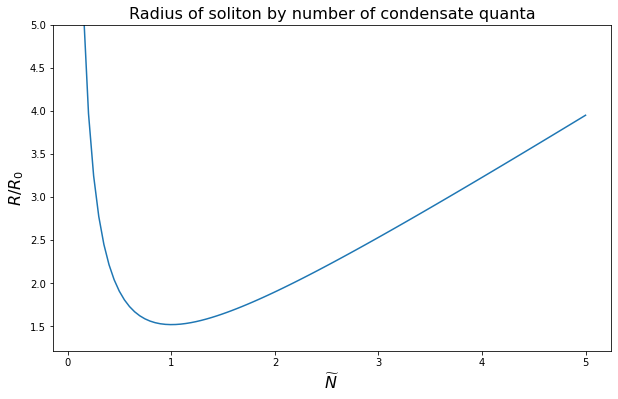

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# plot behavior of R with N
N = np.linspace(0.1, 5, 100)
R = (N**2 + 1)/N/(3**0.25)
opt = {"fontsize": 16}
plt.figure(figsize=(10, 6))
plt.plot(N, R)
plt.xlabel(r"$\widetilde{N}$", **opt)
plt.ylabel(r"$R/R_0$", **opt)
plt.ylim(top=5)
plt.title("Radius of soliton by number of condensate quanta", **opt)
plt.gca().set_facecolor("w")
plt.show()

We can also plug our solution back into the variational energy expression to get the approximate binding energy of the soliton.

In [56]:
R, R0, Nt, N = sp.symbols("R R_0 \widetilde{N} N", positive=True)
(
    E_var
    .subs(R, R0*(Nt**2 + 1)/(sp.Pow(3, sp.Rational(1, 4))*Nt))
    .subs(N, 1/((2*sp.sqrt(a*m))/(sp.Pow(3,sp.Rational(1,4))*sp.sqrt(sp.pi))))
)

-sqrt(3)*sqrt(\alpha)*\bar{\psi}**2*\widetilde{N}/(R_0*sqrt(m)*(\widetilde{N}**2 + 1)) + sqrt(3)*\widetilde{N}**2/(R_0**2*m*(\widetilde{N}**2 + 1)**2)

This can be cleaned up a little bit too:
$$
E = -\sqrt{3} \alpha \bar{\psi}^4 \frac{\widetilde{N}}{\widetilde{N}^2+1} \left( 1 - \frac{\widetilde{N}}{\widetilde{N}^2+1} \right)
$$
Interestingly, the soliton is most strongly bound when $\widetilde{N} \sim 1$. For $\widetilde{N} \ll 1$, it quickly loses its stickiness and dissipates. In the $\widetilde{N} \gg 1$ regime, it continues to stay bound, but since the binding energy asymptotically approches zero instead of growing linearly, it actually becomes more energetically favorable for a large soliton to fracture into multiple smaller solitons, and is likely unstable to perturbations.

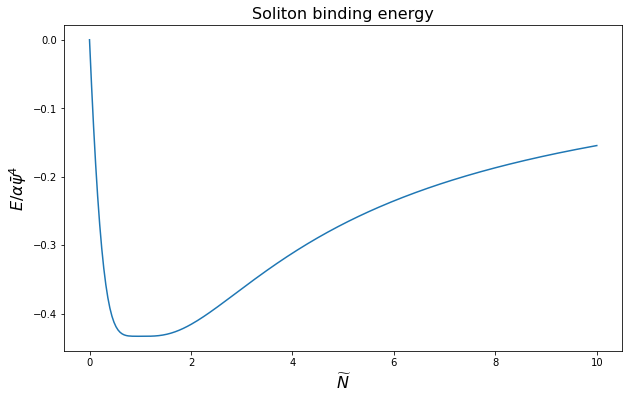

In [68]:
Nt = np.linspace(0, 10, 250)
E = -(3**0.5)*(Nt/(Nt**2+1))*(1 - Nt/(Nt**2+1))
opt = {"fontsize": 16}
plt.figure(figsize=(10, 6))
plt.plot(Nt, E)
plt.xlabel(r"$\widetilde{N}$", **opt)
plt.ylabel(r"$E/\alpha\bar{\psi}^4$", **opt)
plt.title("Soliton binding energy", **opt)
plt.show()

However, in the next section on numerical solutions, we will see that the Gaussian ansatz is perhaps not the best trial wavefunction in the $\tilde{N} \gg 1$ regime, and so we cannot trust this conclusion in that parameter space.

## Numerical simulation

Before attempting numerical calculation of $\psi(x)$, it will be convenient to make a couple transformations to simplify computations.
First of all, from our approximate analysis in the previous section, we expect the width of the soliton to be approximately $O(R)$.
Therefore, it would be prudent to transform our coordinate system like $x \rightarrow R \xi$, so that our new spatial coordinate $\xi$ is now a dimensionless quantity representing lengths in units of $R$.
This means that $\xi \sim O(1)$, simplifying our choice of grid points for numerical simulation.
Second, it will simplify the differential equation itself to transform $\psi \rightarrow \bar{\psi} \chi$.
Third (and as mentioned before), we can see that the the potential is nonzero when $\psi = 0$, which means that there is an infinite vacuum energy.
We can simply subtract off this constant term to get a finite value for the energy.
This does not alter the physics at all (unless considering general relativity), but makes things more numerically stable and easier to understand.
After these transformations, the differential equation looks like

$$
-\frac{1}{2} \frac{d^2\chi}{d\xi^2} + \beta^2\left[\left(|\chi|^2 - 1\right)^2 - 1 \right]\chi = \mathcal{E} \chi \\ \text{where} \quad
\beta = \sqrt{\alpha m} \bar{\psi}^2 R
= R/R_0
= \frac{\widetilde{N}^2 + 1}{3^{1/4}\widetilde{N}}, \quad
\mathcal{E} = m R^2 E
$$
This only has a single dimensionless free parameter $\widetilde{N}$, and a dimensionless energy eigenvalue $\mathcal{E}$.
Keep in mind that the wave function normalization condition is now
$$
\langle \chi | \chi \rangle = \int d\xi\, |\chi|^2
= \int \frac{dx}{R}\, \left|\psi/\bar{\psi}\right|^2
= \frac{N}{R \bar{\psi}^2}
= \frac{3^{1/4} \sqrt{\pi}}{2\beta} \widetilde{N}
= \frac{\sqrt{3\pi}}{2} \frac{\widetilde{N}^2}{\widetilde{N}^2 + 1}.
$$
$\widetilde{N}$ is now the only free parameter in the entire scenario, which means that $\mathcal{E}$ is a function of $\widetilde{N}$ alone.
We can exploit this to solve for the energy spectrum quite easily.

Normally, 1-dimensional Schrodinger equations are solved using a shooting technique that involves integrating the differential equation while performing a bisection search on the energy eigenvalue, with the termination condition being that the boundary conditions are (approximately) satisfied.
However, we can make use of the variational wave function derived above as a starting point.
In terms of $\chi$ and $\xi$, this is now

$$
\chi_0(\xi) = \left[\sqrt{\frac{3}{2}} \frac{\widetilde{N}^2}{\widetilde{N}^2 + 1}\right]^{1/2} e^{-\xi^2}
$$

In [71]:
import numpy as np
from numba import njit # use numba for SPEEEEEEED
import matplotlib.pyplot as plt

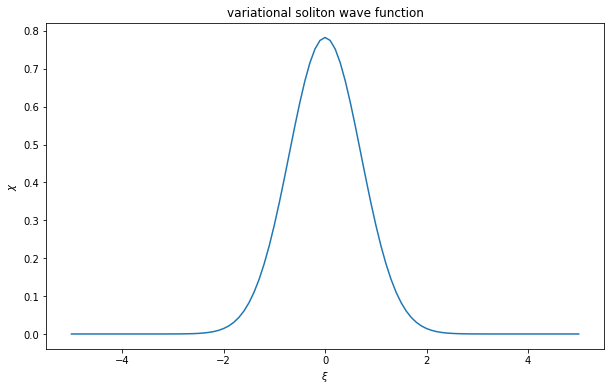

In [86]:
@njit
def init_chi(Nt, xi):
    return np.sqrt(np.sqrt(3/2)*(Nt**2)/(Nt**2+1)) * np.exp(-xi**2)

# declare parameters
xi_min, xi_max = -5, 5
n_points = 101
delta = (xi_max - xi_min)/(n_points - 1)
Nt = 1

# set things up
xi = np.linspace(xi_min, xi_max, n_points)
chi0 = init_chi(Nt, xi)
plt.figure(figsize=(10, 6))
plt.plot(xi, chi0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\chi$")
plt.title("variational soliton wave function")
plt.show()

Following along with with [Ref. 1](https://arxiv.org/abs/1701.08934), we can perform iterative updates to a discretized version of $\chi_0$ in order to relax the solution to the ground state or other low-lying excited states.

The potential is given by $V(\chi) = \beta^2((|\chi|^2-1)^2-1)$

In [73]:
@njit
def potential(chi, Nt):
    beta = (Nt**2 + 1)/((3**0.25)*Nt)
    return (beta**2)*(((chi**2) - 1)**2 - 1)

The expectation values are given by
$$
\begin{align*}
\langle \chi | \chi \rangle &= \delta \sum_i \chi_i^2 \\
\bar{V} = \langle \chi | V | \chi \rangle &= \delta \sum_i V_i \chi_i^2 \\
\bar{K} = \langle \chi | K | \chi \rangle &= -\delta^{-1} \sum_i (\chi_i \bar{\chi}_{nn} - \chi_i^2)
\end{align*}
$$

In [74]:
@njit
def chi_nn(chi):
    # average each point over nearest neighbors
    # assume values outside range are 0
    _chi = np.zeros_like(chi)
    _chi[1:len(chi)-1] = (chi[0:len(chi)-2] + chi[2:len(chi)])/2
    _chi[0] = chi[1]/2
    _chi[-1] = chi[-1]/2
    return _chi

norm = delta * np.sum(chi0**2)
Vbar = delta * np.dot(potential(chi0, Nt), (chi0**2))
Kbar = -np.sum(chi0*chi_nn(chi0) - chi0**2)/delta
(norm, Vbar, Kbar, (Kbar + Vbar)/norm)

(0.7674950309598665,
 -1.1512425464397997,
 0.38278974364252677,
 -1.0012479192682313)

Here is a simple relaxation algorithm to find the true ground state of $\chi$:

In [87]:
@njit
def update(chi, Nt, delta):
    E_arr = np.zeros(1000)
    for i in range(1000):
        # common quantities that will be reused
        _chi_nn = chi_nn(chi)
        chi2 = chi**2
        V0 = potential(chi, Nt)
        # update expectation values
        norm = delta * np.sum(chi2)
        Vbar = delta * np.dot(V0, chi2)
        Kbar = -np.sum(chi*_chi_nn - chi2)/delta
        E = (Kbar + Vbar)/norm
        # update field values
        chi = _chi_nn / (1 - (E - V0)*(delta**2))
        E_arr[i] = E
    return E_arr, chi

In [88]:
E_arr, chif = update(chi0, Nt, delta)

We can tell that the algorithm has converged by looking at the evolution of the variational energy over multiple iterations

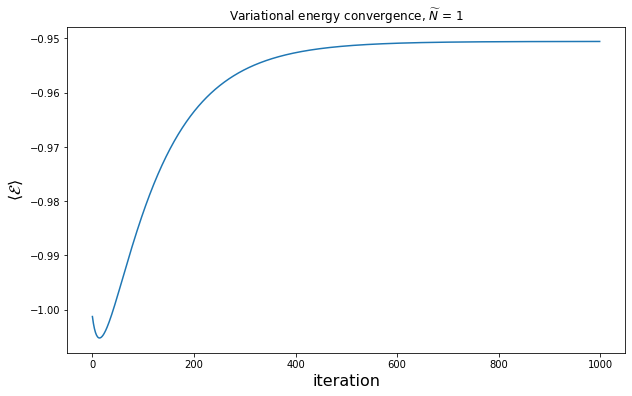

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(E_arr)
plt.xlabel("iteration", fontsize=16)
plt.ylabel(r"$\langle\mathcal{E}\rangle$", fontsize=16)
plt.title(r"Variational energy convergence, $\widetilde{N}$ = " + str(Nt))
plt.show()

We can see that the exact numerical solution is a bit broader than expected by the variational approximation, but that they are roughly the same size and density

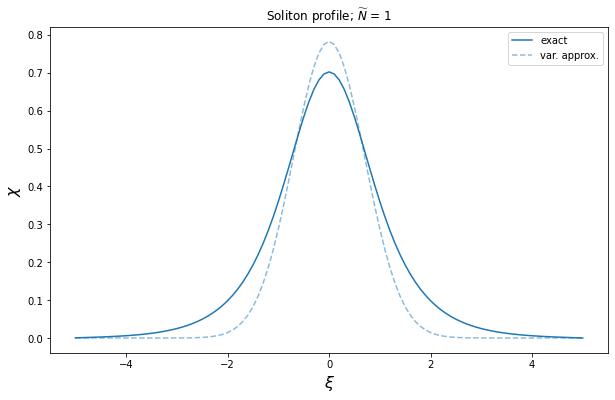

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(xi, chif, label="exact")
plt.plot(xi, chi0, color="C0", alpha=0.5, linestyle="--", label="var. approx.")
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel(r"$\chi$", fontsize=16)
plt.title(r"Soliton profile; $\widetilde{N}$"f" = {Nt}")
plt.legend()
plt.show()

If we crank up the density and self-interaction strength of the soliton, we can see that it develops a nearly uniform density core, and is not as broad/diffuse as before.
This is what is known as a "thin-walled" soliton.

In [91]:
@njit(parallel=True)
def chi_solve(Nt, n_points=101, n_iter=1000, xi_min=-5, xi_max=+5, eps=1e-9):
    delta = (xi_max - xi_min)/(n_points - 1)
    xi = np.linspace(xi_min, xi_max, n_points)
    chi0 = init_chi(Nt, xi)
    chi = chi0
    E_arr = np.zeros(n_iter)
    for i in range(n_iter):
        # common quantities that will be reused
        _chi_nn = chi_nn(chi)
        chi2 = chi**2
        V0 = potential(chi, Nt)
        # update expectation values
        norm = delta * np.sum(chi2)
        Vbar = delta * np.dot(V0, chi2)
        Kbar = -np.sum(chi*_chi_nn - chi2)/delta
        E = (Kbar + Vbar)/norm
        # update field values
        chi = _chi_nn / (1 - (E - V0)*(delta**2)+eps)
        E_arr[i] = E
    return E_arr, xi, chi0, chi

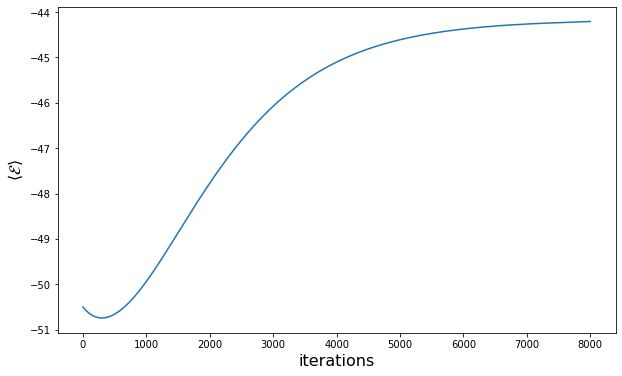

In [92]:
E_arr, xi, chi0, chi = chi_solve(Nt=10, n_iter=int(8.0e3), n_points=2000)
plt.figure(figsize=(10, 6))
plt.plot(E_arr)
plt.xlabel("iterations", fontsize=16)
plt.ylabel(r"$\langle \mathcal{E} \rangle$", fontsize=16)
plt.show()

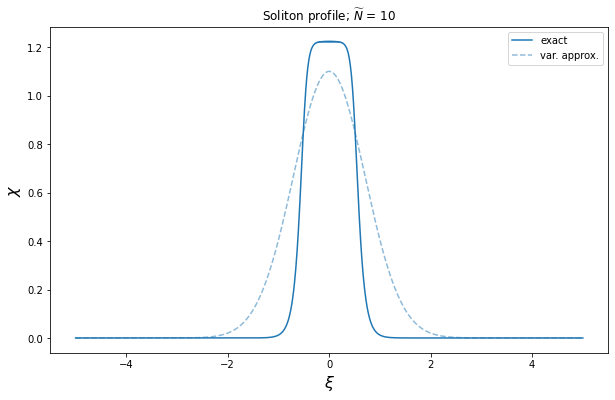

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(xi, chi, label="exact")
plt.plot(xi, chi0, color="C0", alpha=0.5, linestyle="--", label="var. approx.")
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel(r"$\chi$", fontsize=16)
plt.title(r"Soliton profile; $\widetilde{N}$"f" = {10}")
plt.legend()
plt.show()

Recall that $\chi = 1$ is the minimum of the potential, so if the field value gets much higher than that (as the soliton becomes more dense), then an internal pressure is produced which keeps the soliton from collapsing further.